特征矩阵形状: (800, 10000)

10-Fold CV 平均准确率: 0.5713

--- Test Set Classification Report ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.50      0.72      0.59        40
Frontotemporal Dementia       0.60      0.62      0.61        40
     Lewy Body Dementia       0.70      0.53      0.60        40
    Parkinson's Disease       0.72      0.57      0.64        40
      Vascular Dementia       0.71      0.68      0.69        40

               accuracy                           0.62       200
              macro avg       0.64      0.62      0.63       200
           weighted avg       0.64      0.62      0.63       200



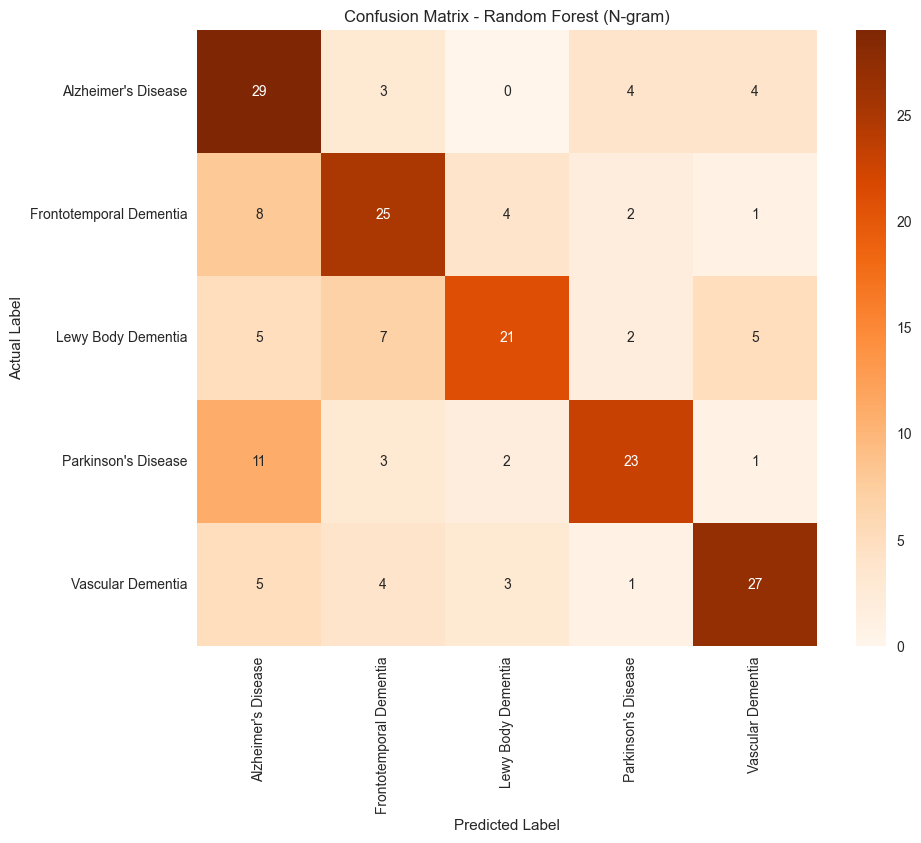

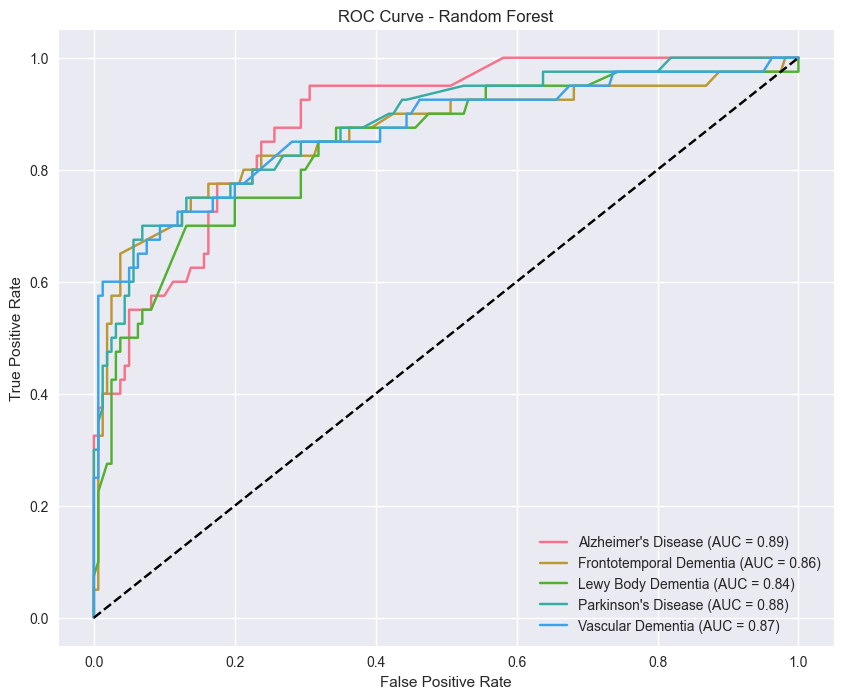

C:\Users\yeyude\AppData\Local\Temp\ipykernel_11236\3174607645.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices], palette="viridis")


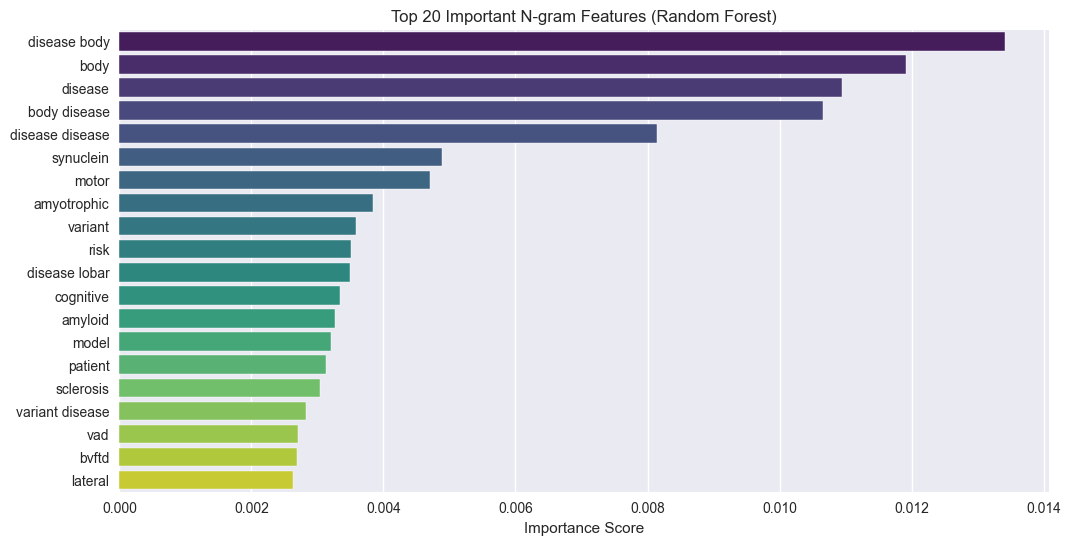

正在训练随机森林模型...

--- Test Set Classification Report ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.56      0.72      0.63        40
Frontotemporal Dementia       0.58      0.65      0.61        40
     Lewy Body Dementia       0.72      0.53      0.61        40
    Parkinson's Disease       0.68      0.57      0.62        40
      Vascular Dementia       0.62      0.62      0.62        40

               accuracy                           0.62       200
              macro avg       0.63      0.62      0.62       200
           weighted avg       0.63      0.62      0.62       200



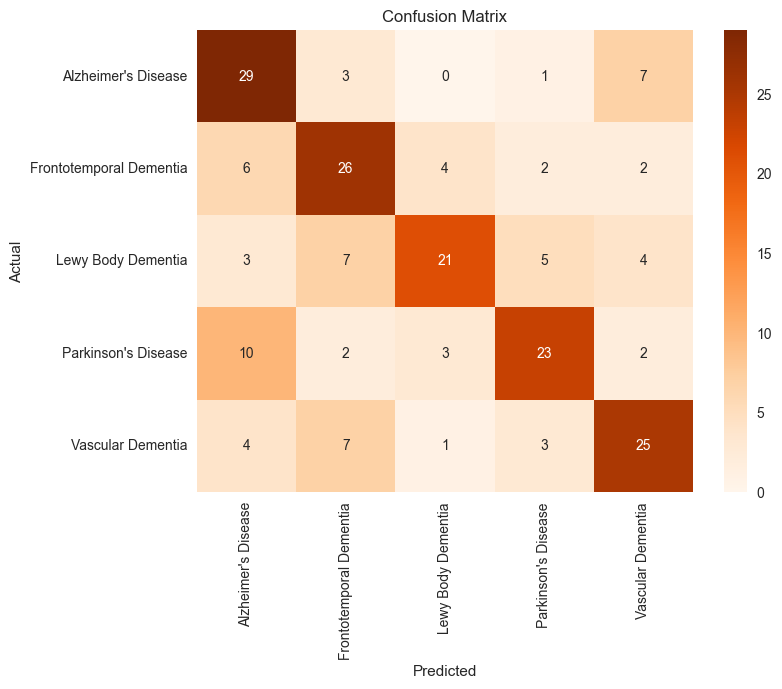


--- Starting SHAP Explainability Analysis ---
共发现 76 个错误分类样本。

[分析样本 ID: 167]
真实标签: Alzheimer's Disease
预测标签: Vascular Dementia (模型犯错了!)
文本片段: population aging one common challenge current world people age body tissue including cell molecule inevitably degrade function gradually decline causi...

正在初始化 SHAP TreeExplainer...
正在计算 SHAP 值 (请耐心等待)...
正在生成针对预测错误类别 'Vascular Dementia' 的 Waterfall 图...


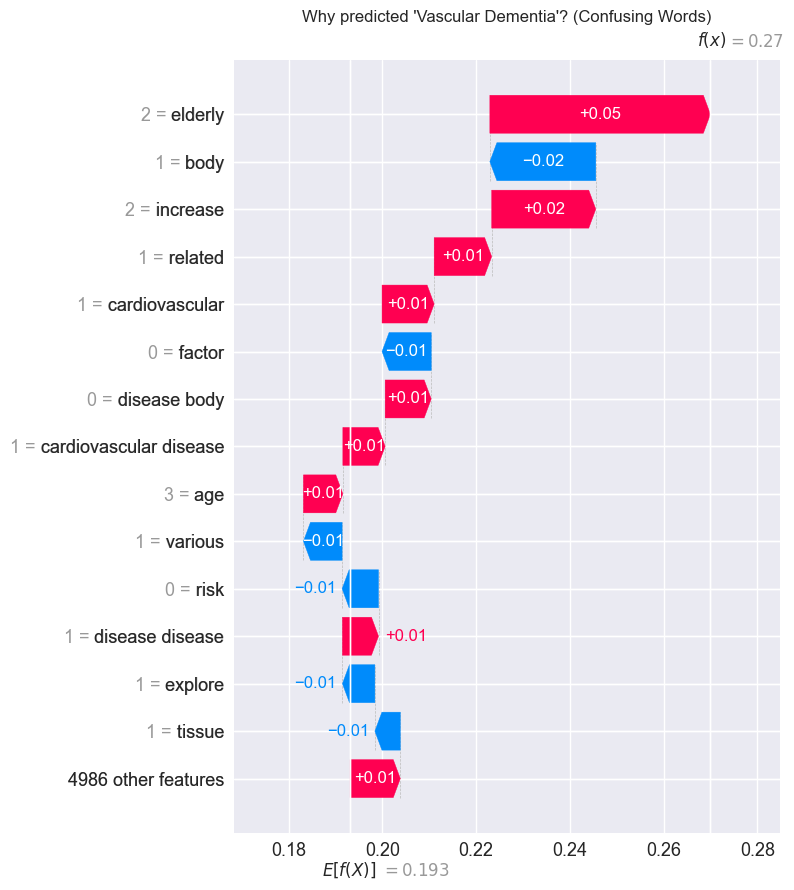


[图表解读指南]:
1. 红色条形 (Red bars): 这些词大大增加了被预测为错误类别的概率 (即混淆词)。
2. 蓝色条形 (Blue bars): 这些词试图把预测拉回正确方向，但失败了。
3. E[f(x)]: 基准概率，即不看任何文本时模型预测该类别的平均概率。
4. f(x): 最终预测得分。


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# 设置绘图风格
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ==========================================
# 1. 数据准备
# ==========================================
df = pd.read_csv('../cleaned_data.csv')
# 确保文本无空值
df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

# 划分训练集和测试集
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['Cleaned_Content'], df['Label'], test_size=0.2, random_state=42, stratify=df['Label']
)

# ==========================================
# 2. 特征工程: N-gram (Unigram + Bigram)
# ==========================================
# 使用 CountVectorizer 提取 1-gram 和 2-gram 特征
# max_features 限制为 10000 个最常见特征，防止随机森林训练过慢
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10000)

X_train_vec = vectorizer.fit_transform(X_train_raw)
X_test_vec = vectorizer.transform(X_test_raw)

print(f"特征矩阵形状: {X_train_vec.shape}")

# ==========================================
# 3. 模型训练: Random Forest Classifier
# ==========================================
# n_estimators=100: 树的数量
# n_jobs=-1: 使用所有CPU核心加速
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 10折交叉验证
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train_vec, y_train, cv=cv, scoring='accuracy')

print(f"\n10-Fold CV 平均准确率: {cv_scores.mean():.4f}")

# 在全量训练集上训练
rf_model.fit(X_train_vec, y_train)

# ==========================================
# 4. 评估与可视化
# ==========================================
y_pred = rf_model.predict(X_test_vec)
y_prob = rf_model.predict_proba(X_test_vec)

print("\n--- Test Set Classification Report ---")
print(classification_report(y_test, y_pred))

# [图表 1] 混淆矩阵 (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - Random Forest (N-gram)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# [图表 2] ROC 曲线
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
classes = lb.classes_

plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

# [图表 3] 特征重要性 (Feature Importance)
# 随机森林可以直接输出特征重要性
feature_names = vectorizer.get_feature_names_out()
importances = rf_model.feature_importances_
# 获取前20个最重要的特征
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices], palette="viridis")
plt.title("Top 20 Important N-gram Features (Random Forest)")
plt.xlabel("Importance Score")
plt.show()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # 确保已安装: pip install shap

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# 设置绘图风格
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ==========================================
# 1. 数据准备与模型训练 (复用之前的逻辑)
# ==========================================
df = pd.read_csv('../cleaned_data.csv')
df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

# 划分训练集和测试集
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['Cleaned_Content'], df['Label'], test_size=0.2, random_state=42, stratify=df['Label']
)

# 特征工程: N-gram
# 注意: SHAP 分析时，特征名字很重要，max_features 不宜过大以免计算太慢
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train_raw)
X_test_vec = vectorizer.transform(X_test_raw)

# 训练随机森林
print("正在训练随机森林模型...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_vec, y_train)

# 预测
y_pred = rf_model.predict(X_test_vec)

# ==========================================
# 2. 基础评估 (Confusion Matrix)
# ==========================================
print("\n--- Test Set Classification Report ---")
print(classification_report(y_test, y_pred))

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
# ==========================================
# 3. SHAP 错误分析 (Explainability)
# ==========================================
print("\n--- Starting SHAP Explainability Analysis ---")

# 步骤 A: 找出预测错误的样本
# 构造一个临时的 DataFrame 方便索引
test_results = pd.DataFrame({
    'Text': X_test_raw, # 原始文本
    'True_Label': y_test,
    'Pred_Label': y_pred
})

# 筛选出 真实标签 != 预测标签 的行
errors = test_results[test_results['True_Label'] != test_results['Pred_Label']]
print(f"共发现 {len(errors)} 个错误分类样本。")

if len(errors) > 0:
    # 步骤 B: 选择一个具体的错误案例进行分析
    # 这里默认取第一个错误样本，您可以修改 iloc[0] 为 iloc[1] 查看其他样本
    error_idx = errors.index[0]

    # 获取该样本在测试集矩阵中的位置索引 (用于提取特征向量)
    loc_idx = list(X_test_raw.index).index(error_idx)

    sample_text = errors.loc[error_idx, 'Text']
    true_label = errors.loc[error_idx, 'True_Label']
    pred_label = errors.loc[error_idx, 'Pred_Label']

    print(f"\n[分析样本 ID: {error_idx}]")
    print(f"真实标签: {true_label}")
    print(f"预测标签: {pred_label} (模型犯错了!)")
    print(f"文本片段: {sample_text[:150]}...") # 打印前150个字符

    # ---------------------------------------------------------
    # 步骤 C: 初始化 SHAP TreeExplainer
    # ---------------------------------------------------------
    print("\n正在初始化 SHAP TreeExplainer...")
    # 针对 Random Forest，TreeExplainer 是最高效的
    # 虽然可以直接用 rf_model，但为了计算基准值(Expected Value)和避免Additivity错误，
    # 建议传入一小部分背景数据 (转为 dense 格式)
    background_data = X_train_vec[:50].toarray()
    explainer = shap.TreeExplainer(rf_model, data=background_data)

    # ---------------------------------------------------------
    # 步骤 D: 计算 SHAP 值
    # ---------------------------------------------------------
    print("正在计算 SHAP 值 (请耐心等待)...")

    # 提取目标样本的特征向量 (转为 dense array)
    target_sample = X_test_vec[loc_idx].toarray()

    # 计算 SHAP 值
    # check_additivity=False 可以防止因浮点数精度问题导致的报错
    shap_values = explainer.shap_values(target_sample, check_additivity=False)

    # ---------------------------------------------------------
    # 步骤 E: 智能可视化 (Waterfall Plot)
    # ---------------------------------------------------------
    print(f"正在生成针对预测错误类别 '{pred_label}' 的 Waterfall 图...")

    # 1. 获取预测类别在模型中的数字索引
    pred_class_idx = list(rf_model.classes_).index(pred_label)

    # 2. 智能提取数据 (兼容不同版本的 SHAP 返回格式: List 或 Array)
    sv_to_plot = None
    base_val_to_plot = None

    if isinstance(shap_values, list):
        # 格式 A: List [class_index][sample_index, feature_index]
        # 对于多分类，SHAP 通常返回一个列表，每个元素对应一个类别的矩阵
        sv_to_plot = shap_values[pred_class_idx][0]
        # expected_value 也可能是列表
        if isinstance(explainer.expected_value, list) or isinstance(explainer.expected_value, np.ndarray):
             base_val_to_plot = explainer.expected_value[pred_class_idx]
        else:
             base_val_to_plot = explainer.expected_value

    elif isinstance(shap_values, np.ndarray):
        # 格式 B: Array (sample, feature, class) 或 (sample, feature)
        if len(shap_values.shape) == 3:
            sv_to_plot = shap_values[0, :, pred_class_idx]
        else:
            # 二分类情况，有时只返回正类的矩阵
            sv_to_plot = shap_values[0]

        # 处理 expected_value
        if hasattr(explainer.expected_value, '__iter__') and len(explainer.expected_value) > 1:
            base_val_to_plot = explainer.expected_value[pred_class_idx]
        else:
            base_val_to_plot = explainer.expected_value

    # 3. 构造 Explanation 对象并绘图
    # 这是绘制 Waterfall 图的标准方式
    explanation = shap.Explanation(
        values=sv_to_plot,                 # 该类别的 SHAP 值
        base_values=base_val_to_plot,      # 基准值 (Base Value)
        data=target_sample[0],             # 原始特征数值 (词频)
        feature_names=vectorizer.get_feature_names_out() # 特征名称 (单词)
    )

    plt.figure(figsize=(10, 8))
    # max_display=15: 只显示影响最大的前 15 个词
    shap.plots.waterfall(explanation, max_display=15, show=False)
    plt.title(f"Why predicted '{pred_label}'? (Confusing Words)")
    plt.tight_layout()
    plt.show()

    print("\n[图表解读指南]:")
    print("1. 红色条形 (Red bars): 这些词大大增加了被预测为错误类别的概率 (即混淆词)。")
    print("2. 蓝色条形 (Blue bars): 这些词试图把预测拉回正确方向，但失败了。")
    print("3. E[f(x)]: 基准概率，即不看任何文本时模型预测该类别的平均概率。")
    print("4. f(x): 最终预测得分。")

else:
    print("恭喜！测试集中没有发现预测错误的样本。")